In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
from skimage.measure import label
from skimage.color import label2rgb
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops
from scipy.spatial import ConvexHull
import cv2 as cv2
import pickle

In [2]:
# read in our original image as grayscale
img = cv2.imread("tafel/Tf001.jpg", cv2.IMREAD_GRAYSCALE)

# bilateral filter
blur = cv2.bilateralFilter(img, 1, 100, 100)

# threshold
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# invert the image using bitwise_not
inverted_image = cv2.bitwise_not(thresh)

# skeletonize
skeleton = skeletonize(inverted_image)


In [3]:
plt.figure(figsize=(200,125))
plt.imshow(skeleton)

In [4]:
def extract_leaf_regions(image_path, landmarks, dilation_iter=2, min_area=500):

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blur = cv2.bilateralFilter(img, 1, 100, 100)

    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    inverted = cv2.bitwise_not(thresh)

    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(inverted, kernel, iterations=dilation_iter)

    labeled = label(dilated)
    props = regionprops(labeled)

    # Assign components to landmarks
    landmark_assignments = {}
    for i, (x, y) in enumerate(landmarks):
        min_dist = float('inf')
        assigned_label = None
        for region in props:
            if region.area >= min_area:
                cy, cx = region.centroid
                dist = np.hypot(cx - x, cy - y)
                if dist < min_dist:
                    min_dist = dist
                    assigned_label = region.label
        landmark_assignments[i] = assigned_label

    # Step 1: Build hull masks with metadata
    hull_masks = []
    for i, region_idx in landmark_assignments.items():
        if region_idx is None:
            hull_masks.append((None, i, 0))
            continue

        component_mask = (labeled == region_idx).astype(np.uint8)
        coords = np.column_stack(np.where(component_mask > 0))
        if coords.shape[0] < 3:
            hull_masks.append((None, i, 0))
            continue

        hull = ConvexHull(coords)
        hull_pts = coords[hull.vertices]
        hull_mask = np.zeros_like(component_mask)
        cv2.fillConvexPoly(hull_mask, hull_pts[:, [1, 0]], 1)

        area = int(np.sum(hull_mask))  # Fix overflow by casting to int
        hull_masks.append((hull_mask, i, area))

    # Step 2: Sort hulls by area (largest first)
    hull_masks.sort(key=lambda x: -x[2])

    # Step 3: Make hulls mutually exclusive
    final_hull_masks = [None] * len(landmarks)
    used_mask = np.zeros_like(img, dtype=bool)
    for hull_mask, idx, _ in hull_masks:
        if hull_mask is None:
            final_hull_masks[idx] = None
            continue
        unique_mask = np.logical_and(hull_mask, ~used_mask)
        used_mask |= unique_mask
        final_hull_masks[idx] = unique_mask.astype(np.uint8)

    # Step 4: Extract outputs
    outputs = []
    for i, mask in enumerate(final_hull_masks):
        if mask is None:
            outputs.append((None, None, None))
            continue
        grayscale_leaf = img * mask
        thresholded_leaf = inverted * mask
        skeleton_leaf = skeletonize(thresholded_leaf > 0).astype(np.uint8)
        outputs.append((grayscale_leaf, thresholded_leaf, skeleton_leaf))

    return outputs


In [5]:
import matplotlib.pyplot as plt

def visualize_leaf_segments_on_image(original_image_path, leaf_outputs, show='skeleton'):
    """
    Overlays skeleton or threshold masks for each leaf on the original image.

    Args:
        original_image_path (str): Path to the original grayscale image.
        leaf_outputs (list of tuples): Output from extract_leaf_regions_updated().
        show (str): 'skeleton' or 'threshold' to control what is overlaid.
    """
    base_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
    base_rgb = cv2.cvtColor(base_image, cv2.COLOR_GRAY2RGB)

    overlay = np.zeros_like(base_rgb)

    # Use a colormap that can be indexed
    colormap = plt.colormaps['tab20']
    num_colors = colormap.N

    for i, (gray, binary, skeleton) in enumerate(leaf_outputs):
        color = np.array(colormap(i % num_colors)[:3]) * 255
        color = color.astype(np.uint8)

        if show == 'threshold':
            mask = binary > 0
        elif show == 'skeleton':
            mask = skeleton > 0
        else:
            raise ValueError("show must be 'skeleton' or 'threshold'")

        for c in range(3):
            overlay[..., c][mask] = color[c]

    # Blend
    alpha = 0.6
    blended = cv2.addWeighted(base_rgb, 1 - alpha, overlay.astype(np.uint8), alpha, 0)

    # Show
    plt.figure(figsize=(12, 12))
    plt.imshow(blended)
    plt.axis('off')
    plt.title(f"Overlay of {show}s on Original Image")
    plt.show()



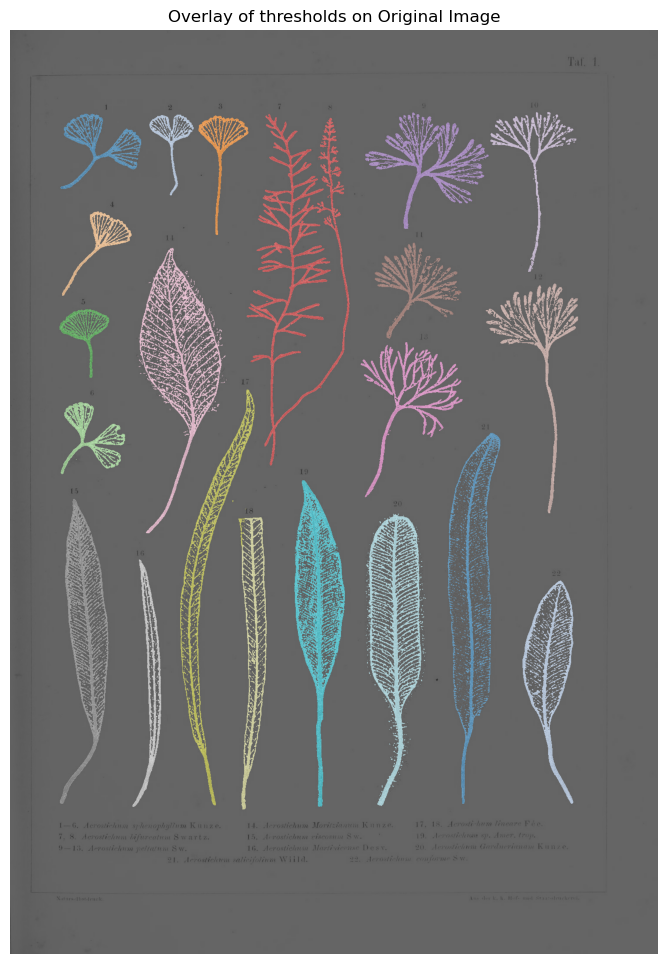

In [6]:
landmark_arr = np.loadtxt("./L001.txt")
landmarks = [tuple(coord) for coord in landmark_arr]

# Extract per-leaf outputs
leaf_data = extract_leaf_regions("modTf001.jpg", landmarks)

# Visualize thresholds
visualize_leaf_segments_on_image("modTf001.jpg", leaf_data, show='threshold')

In [7]:
# SAVE
with open("leaf_outputs.pkl", "wb") as f:
    pickle.dump(leaf_data, f)

In [8]:
# LOAD
with open("leaf_outputs.pkl", "rb") as f:
    leaf_outputs = pickle.load(f)


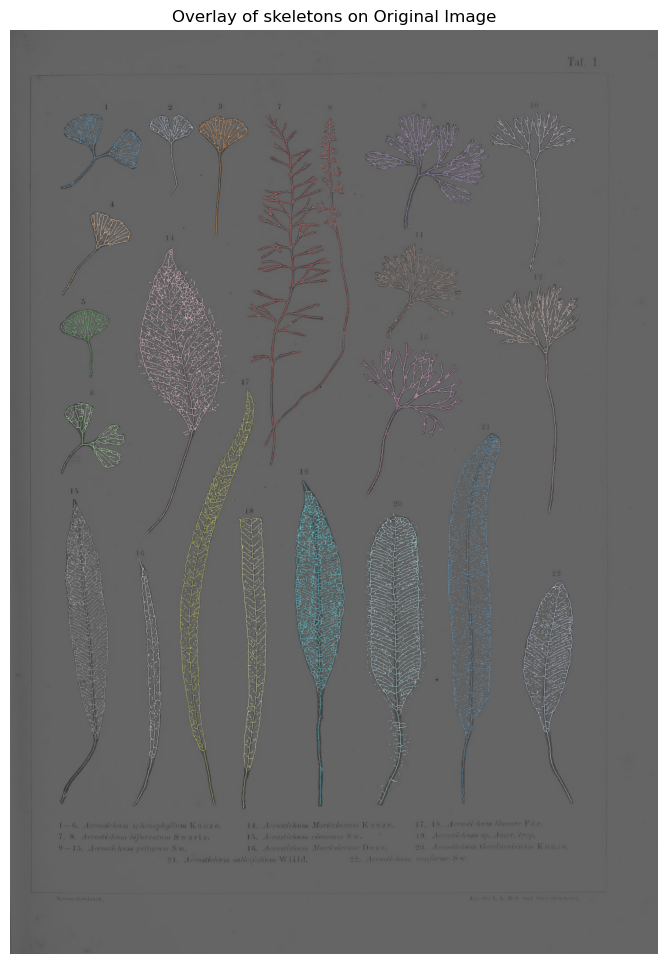

In [9]:
visualize_leaf_segments_on_image("modTf001.jpg", leaf_outputs, show='skeleton')


In [10]:
np.shape(leaf_outputs)

(22, 3, 2128, 1492)

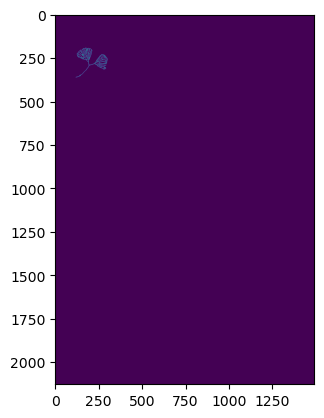

In [14]:
plt.imshow(leaf_outputs[0][2])